In [25]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
import category_encoders as ce
import matplotlib.pyplot as plt

In [9]:
# Métrica de evaluación
def RMSLE(actual, pred):
    actualLog = np.log(actual + 1)
    predLog = np.log(pred + 1)
    return (np.mean((actualLog - predLog) ** 2)) **.5

In [10]:
def normailize_df(refDf, train):
    df = refDf.copy()
    df['año'] = df['fecha'].dt.year
    df['antiguedad'] = df['antiguedad'] + (2016 - df['año']) # Se normaliza la antiguedad.
    df.antiguedad = df.antiguedad.fillna(0) #Asumo que si no tiene antiguedad entonces es nuevo
    df.drop(["direccion", 'descripcion', 'lat', 'lng', 'fecha', 'titulo'], axis=1, inplace=True)
    
    nulltotales = df[df['metrostotales'].isnull()]
    nullcubiertos = df[df['metroscubiertos'].isnull()]
    notnullapart = df[(~ df['metrostotales'].isnull()) & (df['metrostotales'] < df['metroscubiertos'])]
    notnullapart2 = df[(~ df['metrostotales'].isnull()) & (df['metrostotales'] > df['metroscubiertos'])]
    notnullapart3 = df[(~ df['metrostotales'].isnull()) & (df['metrostotales'] == df['metroscubiertos'])]
 
    df['habitable'] = False
    tipodepropiedades = df.tipodepropiedad.cat.categories.to_list()
    for tipodepropiedad in tipodepropiedades: 
              
        idsNullMetrosTotales = (df.tipodepropiedad == tipodepropiedad) & (df.metrostotales.isnull())
        idsNullMetrosCubiertos = (df.tipodepropiedad == tipodepropiedad) & (df.metroscubiertos.isnull())


        ## Verificamos si la cantidad de registros con metros cubiertos nulos es mayor a 2/5 de los totales. Si es asi 
        ## los consideramos propiedades no habitables. Y los tratamos de manera diferente
        if(len(nullcubiertos[nullcubiertos.tipodepropiedad == tipodepropiedad]) >= 2/5* len(df[df.tipodepropiedad == tipodepropiedad])):
            df.metrostotales.fillna(0, inplace=True)
            df.metroscubiertos.fillna(0, inplace=True)
        else:
            df[idsNullMetrosTotales]['metrostotales'] =  df[idsNullMetrosTotales]['metroscubiertos']
            df[idsNullMetrosCubiertos]['metroscubiertos'] =  df[idsNullMetrosCubiertos]['metrostotales']

        #Si la moda del tipo de propiedad de banos y habitaciones son ambas distintas de nan entonces la propiedad es habitable.
        banos = df[df.tipodepropiedad == tipodepropiedad].banos.mode(dropna=False);
        habitaciones = df[df.tipodepropiedad == tipodepropiedad].habitaciones.mode(dropna=False);
        df.loc[(df.tipodepropiedad == tipodepropiedad), 'habitable'] = not(np.isnan(banos[0]) and np.isnan(habitaciones[0]))
    
    df['metros'] = df['metrostotales'] + df['metroscubiertos']
    df.habitaciones = df.habitaciones.fillna(0)
    df.garages = df.garages.fillna(0)
    df.banos = df.banos.fillna(0)

    
    if(train):

        def is_outlier(group):
            Q1 = group.quantile(0.25)
            Q3 = group.quantile(0.75)
            IQR = Q3 - Q1
            precio_min = Q1 - 1.5 * IQR
            precio_max = Q3 + 1.5 * IQR
            return ~group.between(precio_min, precio_max)
        df['precio_mt2'] = df['precio'] / df['metros']
        print()
        
        df = df[~df.groupby('tipodepropiedad')['precio_mt2'].apply(is_outlier).fillna(False)]
        idDel = df[df.tipodepropiedad == 'Garage'].index
        df = df.drop(idDel)
        idDel = df[df.tipodepropiedad == 'Hospedaje'].index
        df = df.drop(idDel)
        print('Despues de filtrar: ', df.shape)
        cols = list(df.columns)
        cols =  cols[:15] + cols[16:] +[cols[15]]
        df = df[cols]

    return df

In [11]:
#Archivos de train y test

df_train = pd.read_csv('data/train.csv',
        index_col='id',
        dtype={'gimnasio': int,
                'usosmultiples': int,
                'escuelascercanas': int,
                'piscina': int,
                'centroscomercialescercanos': int,
                'tipodepropiedad': 'category',
                'provincia': 'category',
                'ciudad': 'category'
            },
        parse_dates=['fecha'])
df_test = pd.read_csv('data/test.csv',
        index_col='id',
        dtype={'gimnasio': int,
                'usosmultiples': int,
                'escuelascercanas': int,
                'piscina': int,
                'centroscomercialescercanos': int,
                'tipodepropiedad': 'category',
                'provincia': 'category',
                'ciudad': 'category'
            },
        parse_dates=['fecha'])

df_train = normailize_df(df_train, True)
df_test = normailize_df(df_test, False)

/home/rama/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/rama/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



Despues de filtrar:  (223475, 20)


In [12]:
cat_features = ['tipodepropiedad', 'provincia', 'ciudad']
target_enc = ce.TargetEncoder(cols=cat_features)

#train, valid, _ = get_data_splits(df_train)

# Fit the encoder using the categorical features and target
target_enc.fit(df_train[cat_features], df_train['precio'])

# Transform the features, rename the columns with _target suffix, and join to dataframe
df_train = df_train.join(target_enc.transform(df_train[cat_features]).add_suffix('_target'))
df_train = df_train.drop(cat_features, axis=1)

df_test = df_test.join(target_enc.transform(df_test[cat_features]).add_suffix('_target'))
df_test = df_test.drop(cat_features, axis=1)
df_test.fillna(0, inplace=True)
#valid = valid.join(target_enc.transform(valid[cat_features]).add_suffix('_target'))

In [13]:
from sklearn.model_selection import GridSearchCV
def algorithm_pipeline(X_train_data, X_test_data, y_train_data, y_test_data, 
                       model, param_grid, cv=10, scoring_fit='neg_mean_squared_error',
                       do_probabilities = False):
    gs = GridSearchCV(
        estimator=model,
        param_grid=param_grid, 
        cv=cv, 
        n_jobs=1, 
        scoring=scoring_fit,
        verbose=2
    )
    fitted_model = gs.fit(X_train_data, y_train_data)
    
    if do_probabilities:
      pred = fitted_model.predict_proba(X_test_data)
    else:
      pred = fitted_model.predict(X_test_data)
    
    return fitted_model, pred

In [14]:
df_train.drop('precio_mt2', axis=1, inplace=True)
X, y = df_train.drop('precio', axis = 1),df_train['precio']

In [15]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = \
    train_test_split(X, y, test_size=0.2, random_state=123)

In [16]:
data_dmatrix = xgb.DMatrix(data=X,label=y)

/home/rama/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/rama/anaconda3/lib/python3.7/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


In [17]:
params = {"objective":"reg:squarederror",
          'learning_rate': 0.1, 'max_depth': 5, 'alpha': 10}


model = xgb.XGBRegressor(objective ='reg:squarederror', 
                learning_rate = 0.1,
                alpha = 10)

param_grid = {
    'n_estimators': [400, 500],
    'colsample_bytree': [0.7, 0.8],
    'max_depth': [5,10],
    'reg_alpha': [1.2, 1.3],
    'reg_lambda': [ 1.3, 1.4],
    'subsample': [0.7, 0.8]
}

In [ ]:
model, pred = algorithm_pipeline(X_train, X_test, y_train, y_test, model, 
                                 param_grid, cv=5)

# Root Mean Squared Error
print(np.sqrt(-model.best_score_))
print(model.best_params_)

El resultado de la anterior corrida da:\
Root Mean Squared Error: 49288.707374858095\
{'colsample_bytree': 0.8, 'max_depth': 10, 'n_estimators': 500, 'reg_alpha': 1.2, 'reg_lambda': 1.4, 'subsample': 0.8}

Entrenamos el set con los valores indicados previamente

In [18]:
xg_reg = xgb.XGBRegressor(objective ='reg:squarederror', 
                colsample_bytree = 0.8, learning_rate = 0.1,
                max_depth = 10, reg_alpha = 1.2, n_estimators = 500, reg_lambda = 1.4, subsample=0.8)

In [19]:
xg_reg.fit(X_train,y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.8, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=10, min_child_weight=1, missing=None, n_estimators=500,
             n_jobs=1, nthread=None, objective='reg:squarederror',
             random_state=0, reg_alpha=1.2, reg_lambda=1.4, scale_pos_weight=1,
             seed=None, silent=None, subsample=0.8, verbosity=1)

In [20]:
preds = xg_reg.predict(X_test)

In [21]:
print(RMSLE(y_test, preds))

0.28640136193455645


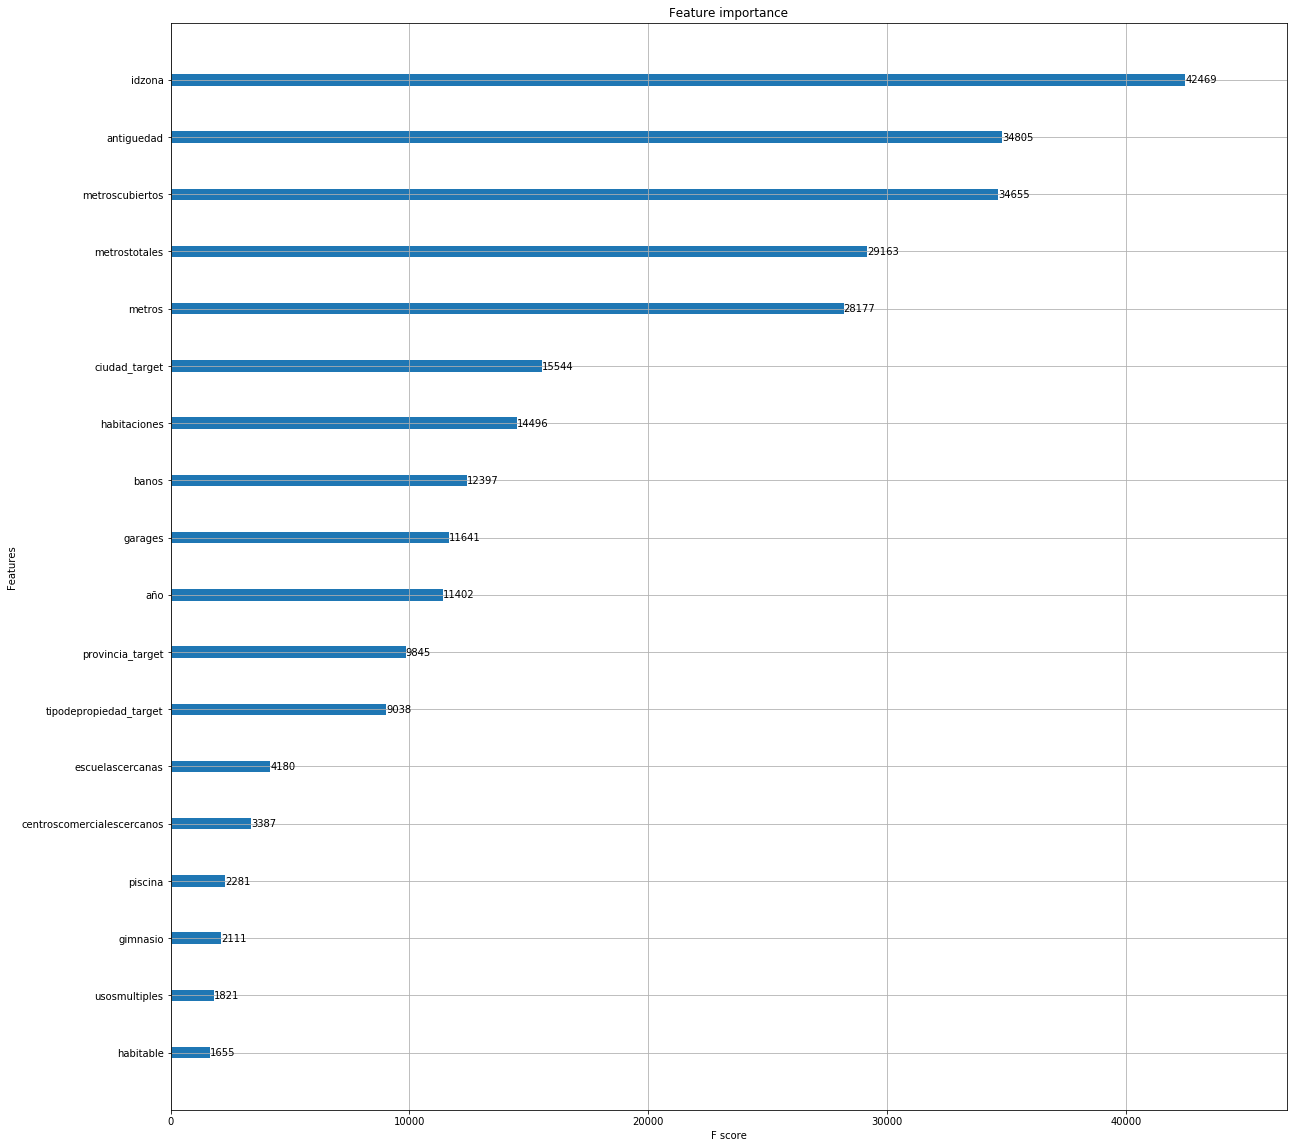

In [26]:
xgb.plot_importance(xg_reg)
plt.rcParams['figure.figsize'] = [17, 17]
plt.show()

## Kaggle Score: 587735.65615

# Set de datos Tom

In [27]:
# Se usaran los sets normalizados bajo columnas SOLAMENTE.
train = pd.read_csv('../normalized_train.csv')
test = pd.read_csv('../normalized_test.csv')

# Casteamos todo a int, esto es porque XgBoost dio problemas usando el set de datos con los datos heredados.
const = ['antiguedad', 'banos', 'garages', 'metroscubiertos', 'metrostotales', 'metros']
every_column_except_y= [col for col in train.columns if col not in ['preciomt2', 'precio','id', 'logpreciomt2', 'fecha', 'descripcion', 'titulo', 'logprecio']]
columns = [col for col in train[every_column_except_y].columns if col not in const]
# columns
train.loc[:, columns] = train[columns].fillna(0)
for column in columns:
    train[column] = train[column].astype('int32')

In [28]:
# Generamos el modelo y un set de test para tener alguna metrica
xg_reg = xgb.XGBRegressor(objective ='reg:squarederror', 
                colsample_bytree = 0.8, learning_rate = 0.1,
                max_depth = 10, reg_alpha = 1.2, n_estimators = 500, reg_lambda = 1.4, subsample=0.8, seed=30)
every_column_except_y= [col for col in train.columns if col not in ['preciomt2', 'precio','id', 'logpreciomt2', 'fecha', 'descripcion', 'titulo', 'logprecio']]

X, y = train.loc[:,every_column_except_y], train['logprecio']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

In [29]:
# Entrenamos
xg_reg.fit(X_train,y_train)

/home/rama/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.8, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=10, min_child_weight=1, missing=None, n_estimators=500,
             n_jobs=1, nthread=None, objective='reg:squarederror',
             random_state=0, reg_alpha=1.2, reg_lambda=1.4, scale_pos_weight=1,
             seed=30, silent=None, subsample=0.8, verbosity=1)

In [30]:
#Predecimos y vemos el error.
pred= xg_reg.predict(X_test)

In [31]:
print(RMSLE(y_test, pred))

0.021509075599998727


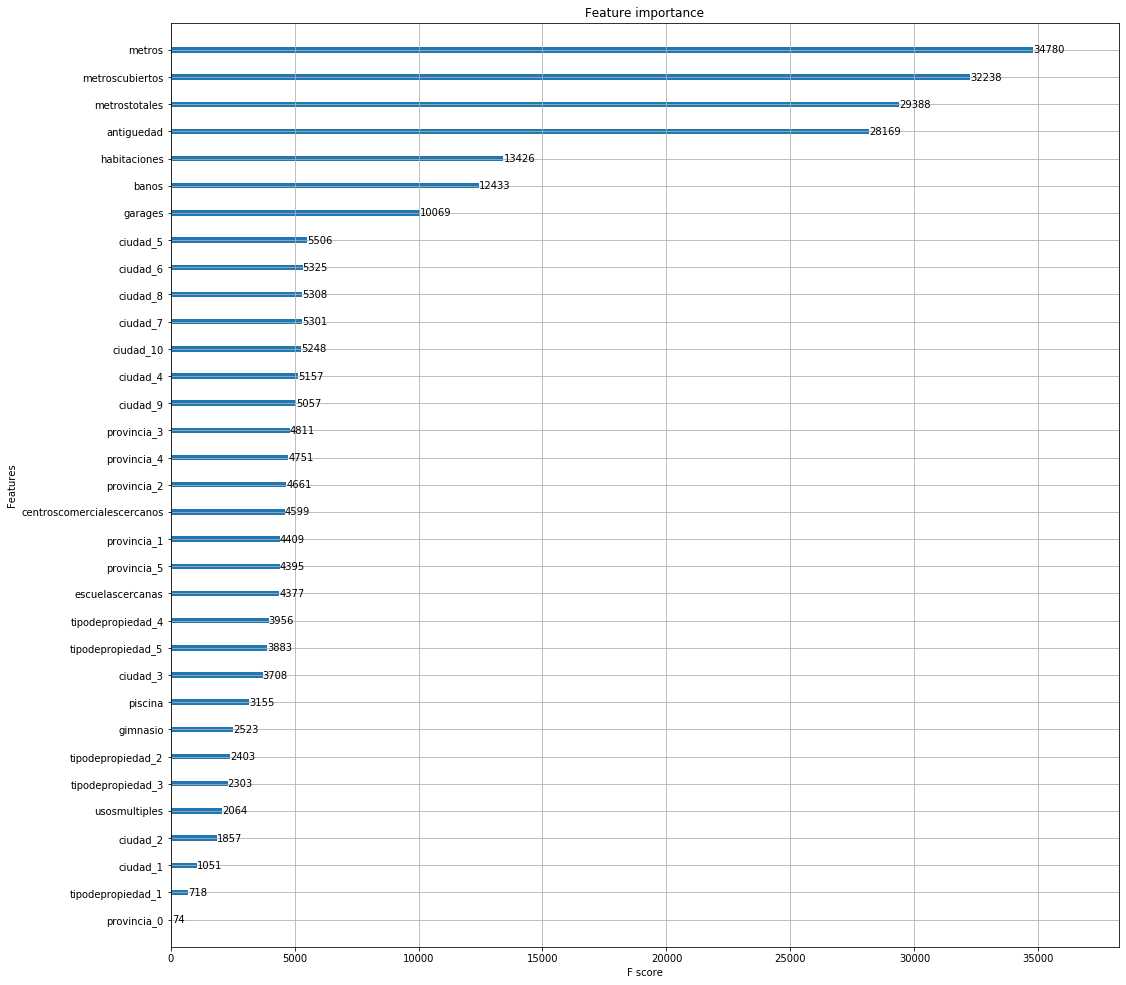

In [32]:
xgb.plot_importance(xg_reg)
plt.rcParams['figure.figsize'] = [17, 17]
plt.show()

## Kaggle Score: 600071.61725

# Normalizacion Gasti

In [64]:
import normalize_data as nP

In [65]:
#Archivos de train y test

df_train = pd.read_csv('data/train.csv',
        index_col='id',
        dtype={'gimnasio': int,
                'usosmultiples': int,
                'escuelascercanas': int,
                'piscina': int,
                'centroscomercialescercanos': int,
                'tipodepropiedad': 'category',
                'provincia': 'category',
                'ciudad': 'category'
            },
        parse_dates=['fecha'])
df_test = pd.read_csv('data/test.csv',
        index_col='id',
        dtype={'gimnasio': int,
                'usosmultiples': int,
                'escuelascercanas': int,
                'piscina': int,
                'centroscomercialescercanos': int,
                'tipodepropiedad': 'category',
                'provincia': 'category',
                'ciudad': 'category'
            },
        parse_dates=['fecha'])

df_train = nP.getNormalizedDataset(df_train, 'train')
df_test = nP.getNormalizedDataset(df_test, 'test')

/home/rama/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)
/home/rama/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/home/rama/Escritorio/UBA/DATOS/TP2/Pruebas/normalize_data.py:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-vie

In [66]:
cat_features = ['tipodepropiedad', 'provincia', 'ciudad']
target_enc = ce.TargetEncoder(cols=cat_features)

#train, valid, _ = get_data_splits(df_train)

# Fit the encoder using the categorical features and target
target_enc.fit(df_train[cat_features], df_train['precio'])

# Transform the features, rename the columns with _target suffix, and join to dataframe
df_train = df_train.join(target_enc.transform(df_train[cat_features]).add_suffix('_target'))
df_train = df_train.drop(cat_features, axis=1)

df_test = df_test.join(target_enc.transform(df_test[cat_features]).add_suffix('_target'))
df_test = df_test.drop(cat_features, axis=1)
#df_test.fillna(0, inplace=True)
#valid = valid.join(target_enc.transform(valid[cat_features]).add_suffix('_target'))

In [67]:
X, y = df_train.drop('precio', axis = 1),df_train['precio']

In [68]:
X_train, X_test, y_train, y_test = \
    train_test_split(X, y, test_size=0.2, random_state=123)

In [69]:
xg_reg = xgb.XGBRegressor(objective ='reg:squarederror', 
                colsample_bytree = 0.8, learning_rate = 0.1,
                max_depth = 10, reg_alpha = 1.2, n_estimators = 500, reg_lambda = 1.4, subsample=0.8)

In [70]:
xg_reg.fit(X_train,y_train)

/home/rama/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.8, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=10, min_child_weight=1, missing=None, n_estimators=500,
             n_jobs=1, nthread=None, objective='reg:squarederror',
             random_state=0, reg_alpha=1.2, reg_lambda=1.4, scale_pos_weight=1,
             seed=None, silent=None, subsample=0.8, verbosity=1)

In [71]:
preds = xg_reg.predict(X_test)

In [72]:
print(X_test.shape)
print(y_test.shape)
print(preds.shape)

(45871, 18)
(45871,)
(45871,)


In [75]:
RMSLE(y_test, preds)

/home/rama/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log
  after removing the cwd from sys.path.


0.32240638220404316

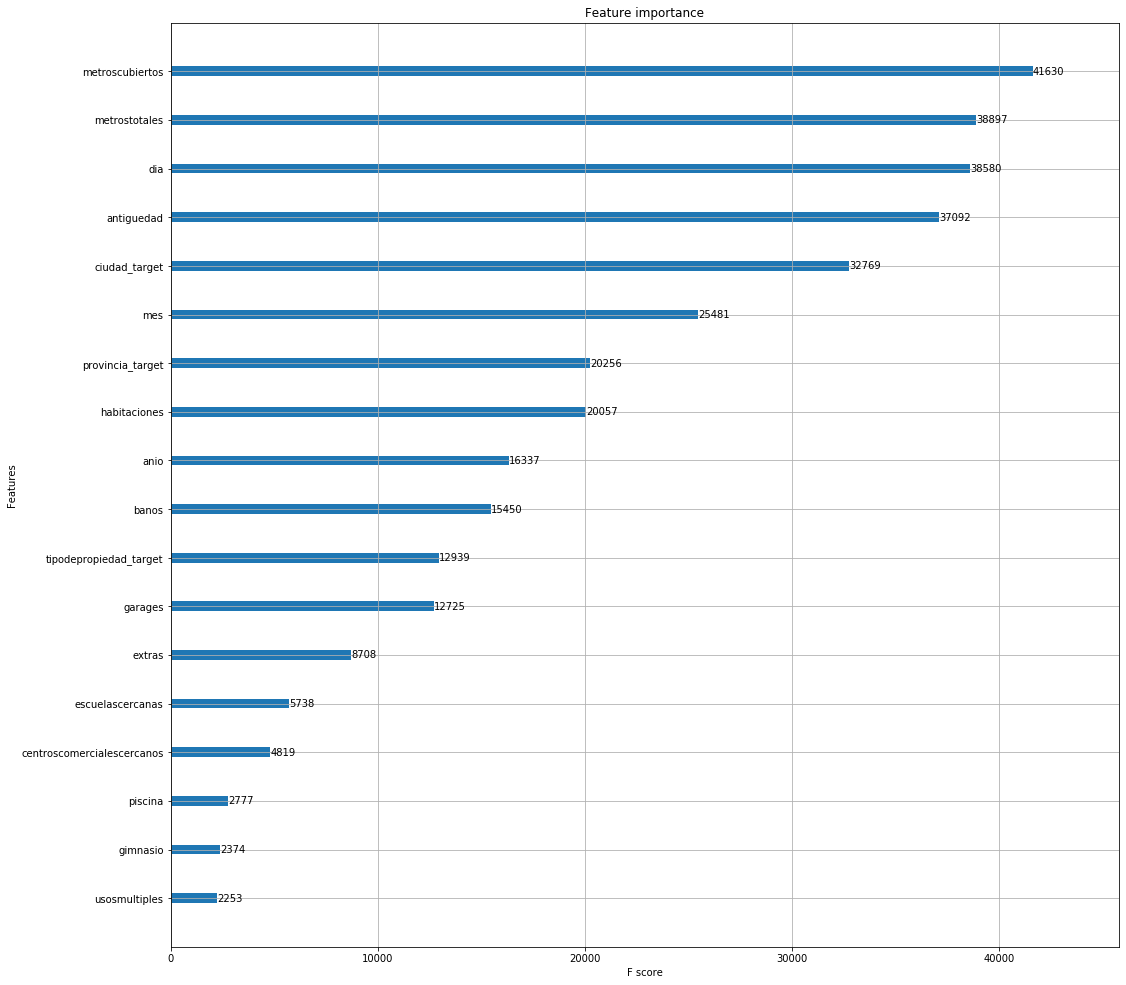

In [74]:
xgb.plot_importance(xg_reg)
plt.rcParams['figure.figsize'] = [17, 17]
plt.show()

In [77]:
X_test = df_test

In [78]:
xg_reg.fit(X,y)

/home/rama/anaconda3/lib/python3.7/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.8, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=10, min_child_weight=1, missing=None, n_estimators=500,
             n_jobs=1, nthread=None, objective='reg:squarederror',
             random_state=0, reg_alpha=1.2, reg_lambda=1.4, scale_pos_weight=1,
             seed=None, silent=None, subsample=0.8, verbosity=1)

In [79]:
preds = xg_reg.predict(X_test)

In [80]:
res = pd.DataFrame(preds, index=df_test.index, columns=['target'])
display(res.head())
res.to_csv("data/workshop-submission-XGBoostGastiRa.csv", header=True)

,target
id,
4941,5092154.000
51775,1053242.625
115253,2413768.000
299321,1600844.750
173570,540941.500


## Kaggle Score: 602677.40214